# Conditional galaxy generation

In the tutorials we have seen different methods to design a generative model based on machine learning, and as an example we have seen an application to galaxy images.

Let's now the <a href="https://zenodo.org/records/3242143" target="_blank">COSMOS</a> galaxy dataset observed by a Hubble Space Telescopy survey. Together with the images, the COSMOS dataset provides properties of the galaxies.
Could you think of a way to design a conditional generative model to perform parameter inference on newly collected galaxies images?

To start off we provide some useful tools to download the dataset and preprocess it, we leave the ML hacking and interpretation to you!

Good luck!

## Loading libraries

In [87]:
import matplotlib.pyplot as plt #pip install matplotlib

import numpy as np
import math, os, random
#from einops import rearrange #pip install einops

from pathlib import Path
from PIL import Image

!pip install astropy
from astropy.io import fits 

from tqdm.notebook import tqdm #pip install tqdm

## Loading dataset
A training sample can be downloaded from here; It's 4.4G in size, so could take a bit of time to download. The code block below should download and untar it, but probably better to do this part manually.

In [11]:
import urllib.request

## Download
url = 'https://zenodo.org/record/3242143/files/COSMOS_23.5_training_sample.tar.gz?download=1'
os.makedirs("./", exist_ok=True)
urllib.request.urlretrieve(url, './COSMOS_23.5_training_sample.tar.gz')

## Untar
os.system("tar -xvf ./COSMOS_23.5_training_sample.tar.gz")

COSMOS_23.5_training_sample/
COSMOS_23.5_training_sample/acs_I_unrot_sci_20_cf.fits
COSMOS_23.5_training_sample/README
COSMOS_23.5_training_sample/real_galaxy_catalog_23.5.fits
COSMOS_23.5_training_sample/real_galaxy_catalog_23.5_fits.fits
COSMOS_23.5_training_sample/real_galaxy_catalog_23.5_selection.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n1.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n10.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n11.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n12.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n13.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n14.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n15.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n16.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n17.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n18.fits
COSMOS_23.5_training_sample/real_galaxy_images_23.5_n19.fits
COSMOS_23.5_training_s

0

### explore the content of this dataset

In [6]:
# Path to COSMOS dataset
catalog_folder = Path("./COSMOS_23.5_training_sample/")

The README file contains all the details about the dataset

In [10]:
os.system("cat %s/README"%(catalog_folder))

This README file describes the COSMOS F814W<23.5 training sample distributed for use with GalSim (it
was also used in nearly identical format for the GREAT3 challenge).

(1) The catalog itself is real_galaxy_catalog_23.5.fits.  This file can be used to initialize a
galsim.RealGalaxyCatalog or galsim.COSMOSCatalog instance, and contains a FITS table that could 
also be read in directly using e.g. python or IDL.  The fields that are included for each 
galaxy are:

IDENT: COSMOS identifier from the Leauthaud et al. (2010) catalog.  Please be aware that the COSMOS
catalog has been updated, which resulted in changed identifiers for some objects between different
catalog versions.  You should therefore not rely on this IDENT for cross-matching between other
COSMOS catalogs unless you are sure that the system of identifiers is the same.

RA, DEC: Right ascension and declination (J2000, degrees).  While this is not needed for image
simulation, it is necessary for proper cross-matching with oth

0

er catalogs.

MAG: F814W magnitude (MAG_AUTO in COSMOS catalog).

BAND: Passband for the observed image (F814W in all cases).

WEIGHT: A weight factor to use to account for the fact that larger galaxies are preferentially
excluded from this catalog due to the proximity to CCD edges.

GAL_FILENAME: Name of the file containing the galaxy image.  This is just a filename, not including
a full path.

PSF_FILENAME: Name of the file containing the PSF image for this galaxy.  This is just a filename,
not including a full path.

GAL_HDU: HDU containing the image of this galaxy in the file called GAL_FILENAME.

PSF_HDU: HDU containing the image of the PSF for this galaxy in the file called PSF_FILENAME.

PIXEL_SCALE: pixel scale for the galaxy and PSF images in arcsec (0.03 in all cases).

NOISE_MEAN: mean value of the pixels in the image that do not contain the galaxy.

NOISE_VARIANCE: variance of the pixel values for pixels in the image that do not contain the galaxy.


(2) The files containin

In [68]:
# read info
with fits.open("%s/real_galaxy_catalog_23.5.fits"%(catalog_folder)) as hdul:
    hdul.info()
    print(list(hdul[1].header.keys()))#['IDENT']
    # example of information for one galaxy (point 2 in README)
    print(hdul[1].data[1])


Filename: COSMOS_23.5_training_sample/real_galaxy_catalog_23.5.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     38   56062R x 15C   [J, D, D, D, 5A, D, 32A, 36A, J, J, D, D, D, 26A, D]   
['XTENSION', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'PCOUNT', 'GCOUNT', 'TFIELDS', 'TTYPE1', 'TFORM1', 'TTYPE2', 'TFORM2', 'TTYPE3', 'TFORM3', 'TTYPE4', 'TFORM4', 'TTYPE5', 'TFORM5', 'TTYPE6', 'TFORM6', 'TTYPE7', 'TFORM7', 'TTYPE8', 'TFORM8', 'TTYPE9', 'TFORM9', 'TTYPE10', 'TFORM10', 'TTYPE11', 'TFORM11', 'TTYPE12', 'TFORM12', 'TTYPE13', 'TFORM13', 'TTYPE14', 'TFORM14', 'TTYPE15', 'TFORM15']
(143346, 150.407654, 2.789613, 21.783000946044922, 'F814W', 0.23533999919891357, 'real_galaxy_images_23.5_n1.fits', 'real_galaxy_PSF_images_23.5_n1.fits', 1, 1, 0.029999999329447746, 8.363179949810728e-05, 7.077239843056304e-06, 'acs_I_unrot_sci_20_cf.fits', 48.33710224301831)


In [72]:
# Magnitude
magnitudes = []
with fits.open("%s/real_galaxy_catalog_23.5.fits"%(catalog_folder)) as hdul:
    i=0
    for galaxy in hdul[1].data:
        if i<=10: print(galaxy[3])
        magnitudes.append(galaxy[3])
        i+=1

21.041000366210938
21.783000946044922
22.86199951171875
22.229999542236328
23.284000396728516
22.503999710083008
22.70599937438965
22.131000518798828
22.531999588012695
22.312999725341797
21.631999969482422


In [76]:
# Path to COSMOS dataset
catalog_folder = Path("./COSMOS_23.5_training_sample/")

# Combine the 57 catalogs into a single array
galaxy_images = []
catalogs = catalog_folder.glob("real_galaxy_images_23.5_n*.fits")
for catalog in tqdm(catalogs):
    for galaxies in fits.open(catalog):
        galaxy_images.append(galaxies.data)

0it [00:00, ?it/s]

In [77]:
print(len(magnitudes), len(galaxy_images))

56062 56062


### some preprocessing

In [78]:
n_xy = 64  # Number of pixels to downsample the image to

galaxy_images_cropped_downsampled = []
magnitudes_cropped_downsampled = []
# Loop over all images, crop and downsample
for idx, galaxy_image in enumerate(tqdm(galaxy_images)):
    im = Image.fromarray(galaxy_image)
    
    ## Cropping
    width, height = galaxy_image.shape
    new_dim = np.min([width, height])
    
    # If the image is smaller than the minimum downsampled dimension, skip it
    if new_dim < n_xy:
        continue

    left = (width - new_dim) / 2
    top = (height - new_dim) / 2
    right = width - np.ceil((width - new_dim) / 2)
    bottom =  height - np.ceil((height - new_dim) / 2)

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    
    # Resize/downsample the image
    im = np.array(im.resize((n_xy, n_xy)))
    
    # Append cropped and downsampled image to list
    galaxy_images_cropped_downsampled.append(im)
    magnitudes_cropped_downsampled.append(magnitudes[idx])
galaxy_images_cropped_downsampled = np.array(galaxy_images_cropped_downsampled)
magnitudes_cropped_downsampled = np.array(magnitudes_cropped_downsampled)

  0%|          | 0/56062 [00:00<?, ?it/s]

In [79]:
np.save('./galaxy_images_cropped_downsampled.npy', galaxy_images_cropped_downsampled)
np.save('./galaxy_magnitudes_cropped_downsampled.npy', magnitudes_cropped_downsampled)

In [80]:
print(len(magnitudes_cropped_downsampled), len(galaxy_images_cropped_downsampled))

45560 45560


#### visualize data
when working on a dataset for the first time, it is always useful to plot a subset of the training points and obeserve the relevant properties of the dataset. In the following we plot the marginals of the training data distribution. From the plots it becomes evident a peculiar feature of this dataset, often referred to as *zero padding*, namely the practice of filling with zeros the entries corresponding to specific objects that are not observed in the event.

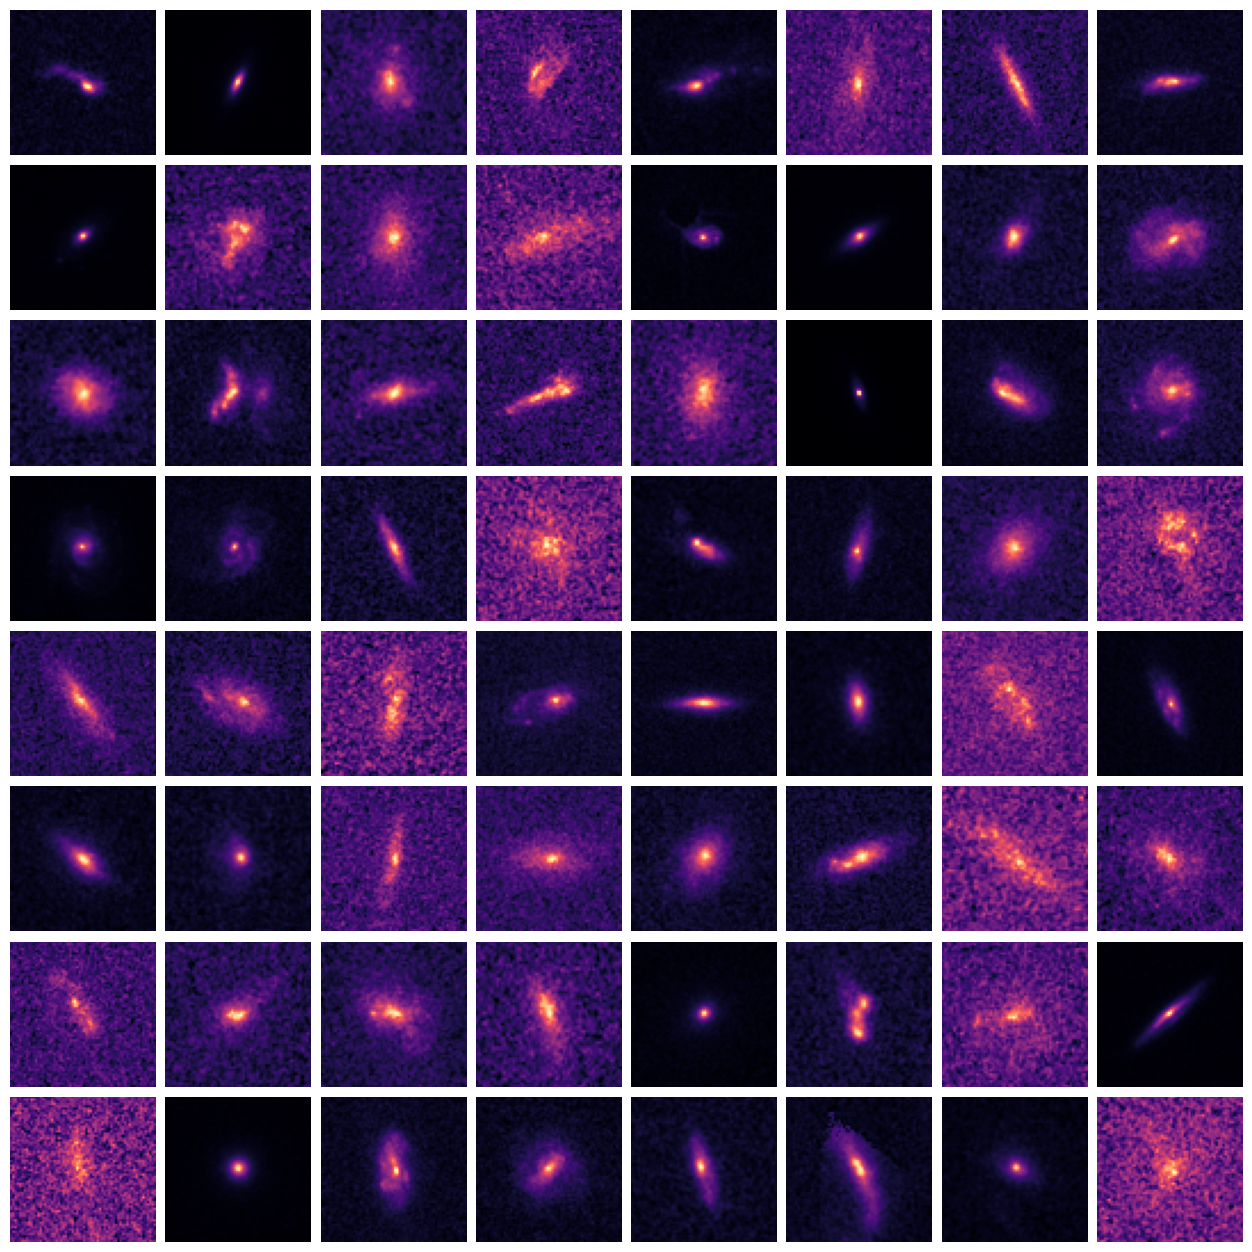

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(8, 8),axes_pad=0.1,)

for ax, im in zip(grid, galaxy_images_cropped_downsampled[np.random.randint(len(galaxy_images_cropped_downsampled), size=64)]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()

(array([1.2000e+01, 5.0000e+01, 1.6300e+02, 4.1900e+02, 9.3900e+02,
        1.9700e+03, 3.7820e+03, 7.0780e+03, 1.1725e+04, 1.9422e+04]),
 array([16.11800003, 16.85620003, 17.59440002, 18.33260002, 19.07080002,
        19.80900002, 20.54720001, 21.28540001, 22.02360001, 22.7618    ,
        23.5       ]),
 <BarContainer object of 10 artists>)

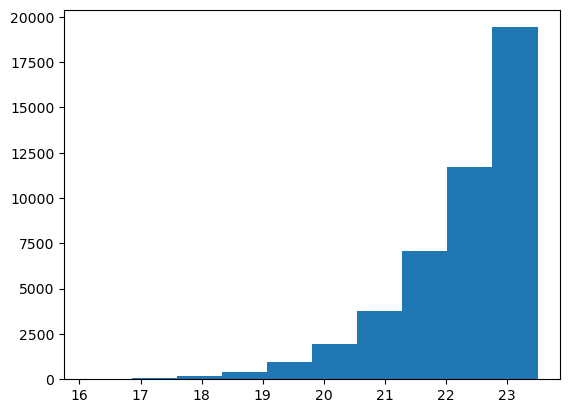

In [81]:
plt.hist(magnitudes_cropped_downsampled)

In [83]:
np.sum(magnitudes_cropped_downsampled<19)

599

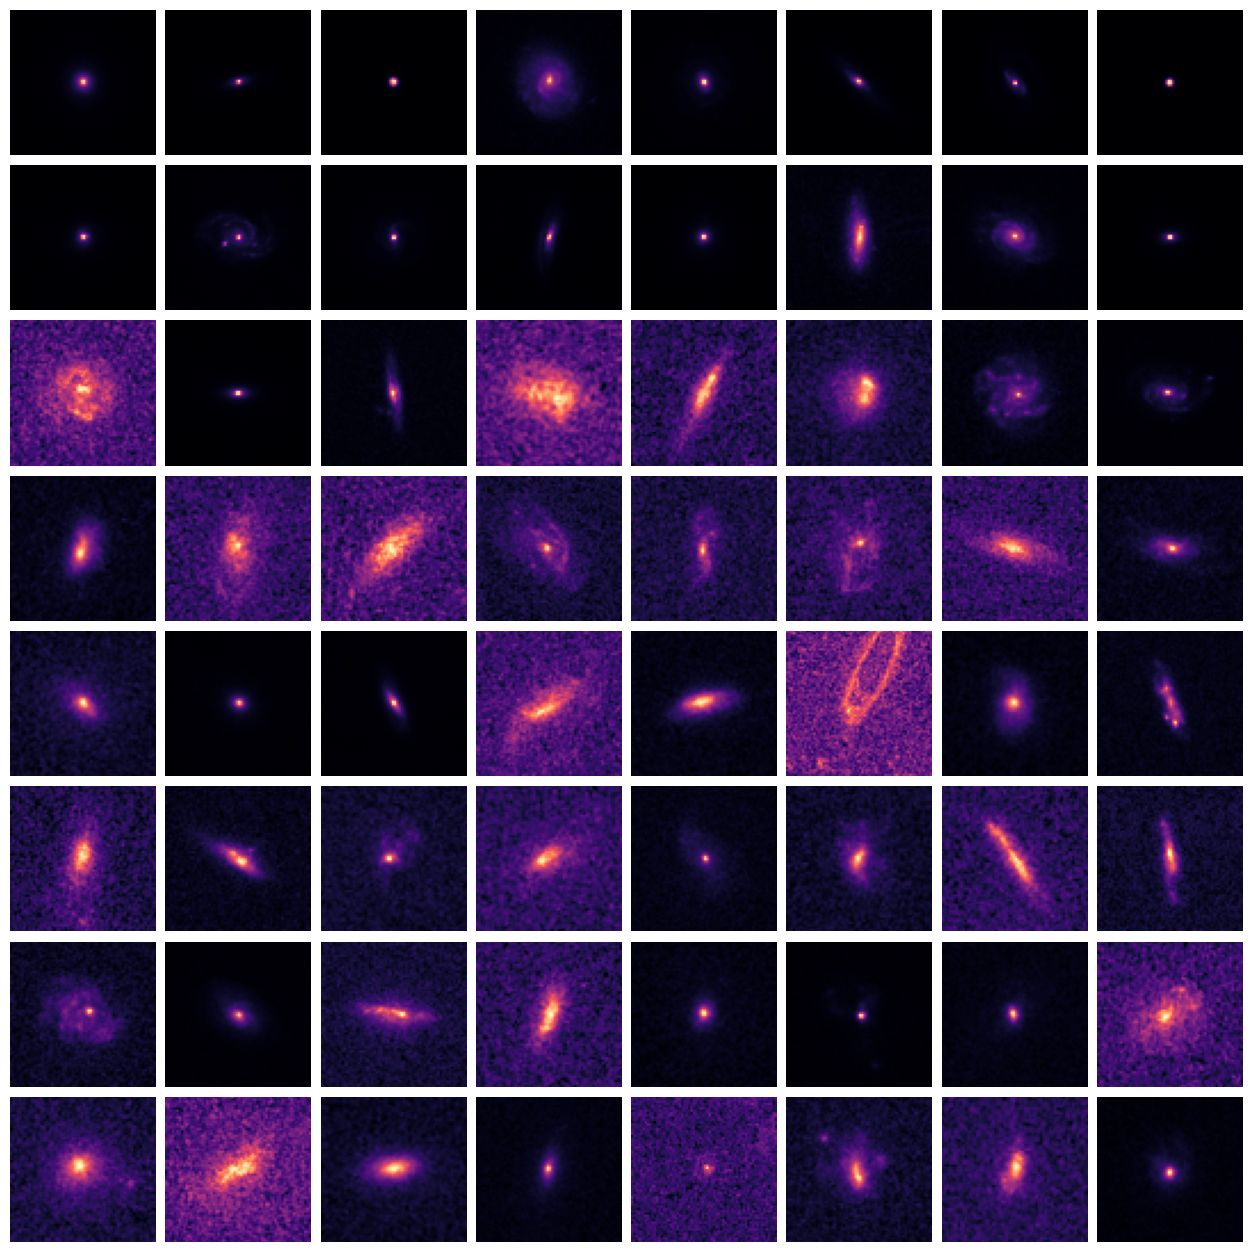

In [84]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(8, 8),axes_pad=0.1,)

for ax, im in zip(grid, galaxy_images_cropped_downsampled[magnitudes_cropped_downsampled<19]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()

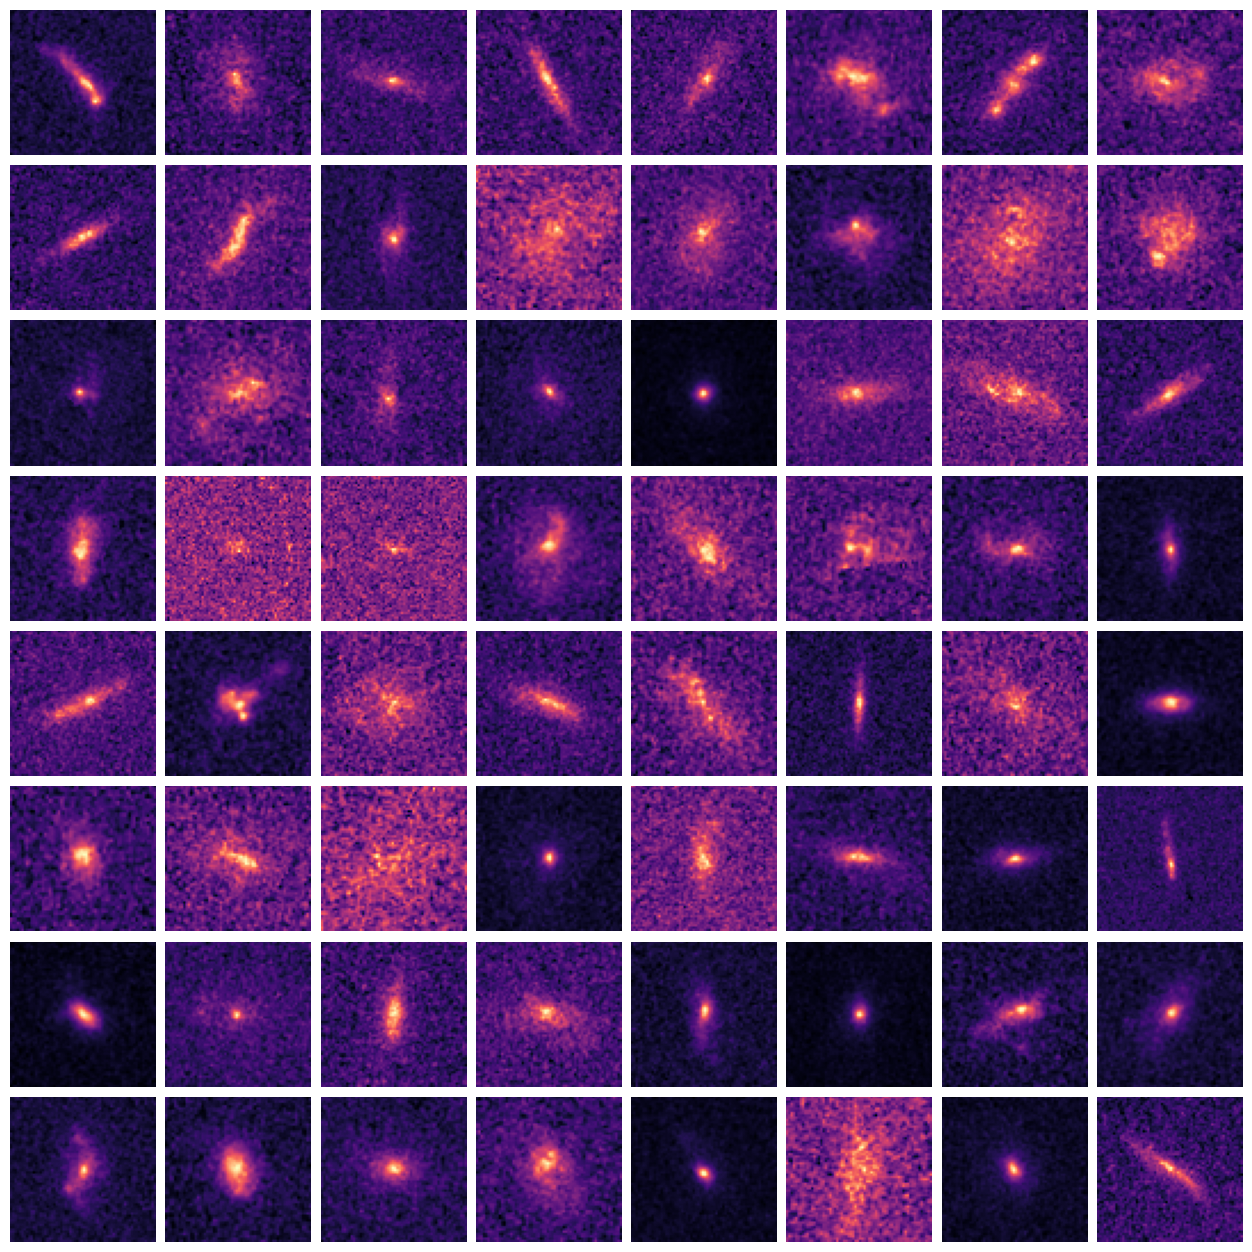

In [86]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(8, 8),axes_pad=0.1,)

for ax, im in zip(grid, galaxy_images_cropped_downsampled[magnitudes_cropped_downsampled>23]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()